In [ ]:
from fastai import *
from fastai.vision import *

The blog can be found at this [link]().

In [ ]:
# Code for Weight Standardization
class Conv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride,
                 padding, dilation, groups, bias)

    def forward(self, x):
        weight = self.weight
        weight_mean = weight.mean(dim=1, keepdim=True).mean(dim=2,
                                  keepdim=True).mean(dim=3, keepdim=True)
        weight = weight - weight_mean
        std = weight.view(weight.size(0), -1).std(dim=1).view(-1, 1, 1, 1) + 1e-5
        weight = weight / std.expand_as(weight)
        return F.conv2d(x, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

### Define model
I test with Resnet-18

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1, norm_layer=None, use_ws=False):
        super().__init__()
        if use_ws:
            my_conv = Conv2d
        else:
            my_conv = nn.Conv2d
    
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1:
            raise ValueError('BasicBlock only supports groups=1')
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = my_conv(inplanes, planes, kernel_size=3, stride=stride, padding=1, groups=groups, bias=False)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = my_conv(planes, planes, kernel_size=3, padding=1, groups=groups, bias=False)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
    
class ResNet(nn.Module):
    def __init__(self, block, layers, use_ws=False, num_classes=1000, zero_init_residual=False,
                     groups=1, width_per_group=64, norm_layer=None):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
            
        if use_ws:
            self.my_conv = Conv2d
        else:
            self.my_conv = nn.Conv2d
        self.use_ws = use_ws
        
        planes = [int(width_per_group * groups * 2 ** i) for i in range(4)]
        self.inplanes = planes[0]
        self.conv1 = self.my_conv(3, planes[0], kernel_size=3, stride=1, padding=0,
                               bias=False)
        self.bn1 = norm_layer(planes[0])
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, planes[0], layers[0], groups=groups, norm_layer=norm_layer)
        self.layer2 = self._make_layer(block, planes[1], layers[1], stride=2, groups=groups, norm_layer=norm_layer)
        self.layer3 = self._make_layer(block, planes[2], layers[2], stride=2, groups=groups, norm_layer=norm_layer)
        self.layer4 = self._make_layer(block, planes[3], layers[3], stride=2, groups=groups, norm_layer=norm_layer)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(planes[3] * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, groups=1, norm_layer=None):
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                self.my_conv(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, groups, norm_layer, use_ws=self.use_ws))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=groups, norm_layer=norm_layer, use_ws=self.use_ws))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
resnet18 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10)
resnet18_ws = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10, use_ws=True)

# Save state dict, so we have same model weights
state_dict = resnet18.state_dict()
resnet18_ws.load_state_dict(state_dict)

def get_models():
    resnet18 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10)
    resnet18_ws = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10, use_ws=True)

    # Save state dict, so we have same model weights
    state_dict = resnet18.state_dict()
    resnet18_ws.load_state_dict(state_dict)
    
    return resnet18, resnet18_ws

## Load data

In [ ]:
# For the data I use CIFAR-10
path = Path('/home/kushaj/Desktop/Data/cifar10/')
src = (ImageList.from_folder(path)
                 .split_by_folder()
                 .label_from_folder())

In [ ]:
data = (src.transform(size=(32, 32))
           .databunch(path, 64)
           .normalize(cifar_stats))

## Start experimentation

In [ ]:
# The paper proved that Weight standardization smoothened the loss surface.
# If that is true then we should be able to train our model with higher 
# learning rate. So we test that now using lr_find

In [ ]:
learn = Learner(data, resnet18)
learn_ws = Learner(data, resnet18_ws)

In [ ]:
# First I test for model with only Batch Norm
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


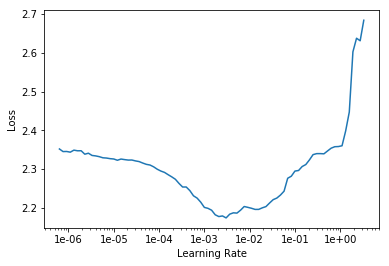

In [ ]:
lr_find = learn.recorder.plot(return_fig=True)

In [ ]:
learn_ws.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


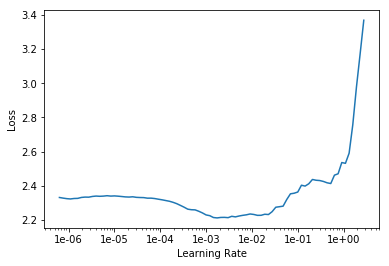

In [ ]:
lr_find_ws = learn_ws.recorder.plot(return_fig=True)

In [ ]:
# There is some reason to believe that we can train at higher learning rate
# but the proof is not much significant.

# So how about we train them for some epochs and see which gives smalle loss.

In [ ]:
learn.fit_one_cycle(3, max_lr=0.0005)

epoch,train_loss,valid_loss,time
0,1.073306,1.095837,03:04
1,0.667810,0.688976,03:05
2,0.389454,0.508198,03:05


In [ ]:
# For now let's test with the same learning rate
learn_ws.fit_one_cycle(3, max_lr=0.0005)

epoch,train_loss,valid_loss,time
0,1.029879,1.033030,03:28
1,0.639364,0.666070,03:27
2,0.367526,0.504515,03:34


Let's try out for smaller batch size like 2

In [ ]:
data = (src.transform(size=(32, 32))
           .databunch(path, 2)
           .normalize(cifar_stats))

resnet18_micro, resnet18_ws_micro = get_models()

learn_micro = Learner(data, resnet18_micro)
learn_ws_micro = Learner(data, resnet18_ws_micro)

In [ ]:
learn_micro.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


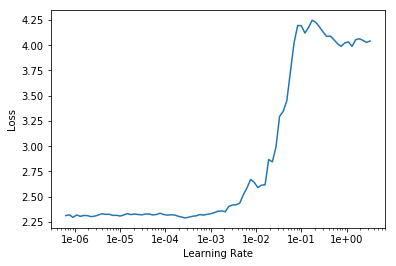

In [ ]:
learn_micro.recorder.plot()

In [ ]:
learn_ws_micro.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


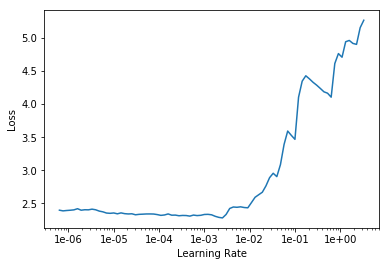

In [ ]:
learn_ws_micro.recorder.plot()

In [ ]:
# Here the only difference that I could notice is, in case of learn_micro
# the learn diverged more quickly, than in case of learn_ws_micro. This 
# fact supports the idea presented in the paper, as the only reason the loss
# did not diverge in the second case was, because Weight Standardization made
# the loss surface smoother.

In [ ]:
learn_micro.fit_one_cycle(3, max_lr=0.00005)

epoch,train_loss,valid_loss,time
0,1.373090,1.246792,18:28
1,0.918476,0.802182,18:21
2,0.550664,0.695172,18:24


In [ ]:
learn_ws_micro.fit_one_cycle(3, max_lr=0.00005)

epoch,train_loss,valid_loss,time
0,1.307534,1.201807,31:50
1,0.835780,0.793317,31:37
2,0.665657,0.670581,33:23


In [ ]:
resnet18_micro, resnet18_ws_micro = get_models()
learn_ws_micro2 = Learner(data, resnet18_ws_micro)

In [ ]:
learn_ws_micro2.fit_one_cycle(2, max_lr=0.001)

epoch,train_loss,valid_loss,time
0,1.033272,0.985062,33:18
1,0.575197,0.644893,31:32


In [ ]:
learn_micro2 = Learner(data, resnet18_micro)

In [ ]:
learn_micro2.fit_one_cycle(2, max_lr=0.001)

epoch,train_loss,valid_loss,time
0,1.056560,0.948750,18:56
1,0.698630,0.677414,18:27


In [ ]:
data = (src.transform(size=(32, 32))
           .databunch(path, 256)
           .normalize(cifar_stats))

resnet18_large, resnet18_ws_large = get_models()
learner_large = Learner(data, resnet18_large)
learner_ws_large = Learner(data, resnet18_ws_large)

In [ ]:
learner_large.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


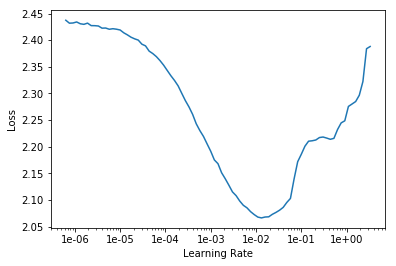

In [ ]:
learner_large.recorder.plot()

In [ ]:
learner_ws_large.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


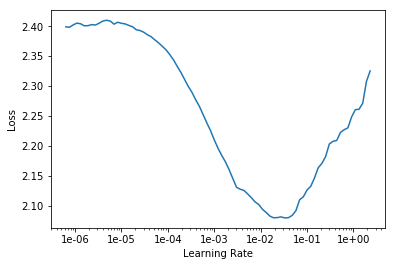

In [ ]:
learner_ws_large.recorder.plot()

In [ ]:
learner_large.fit_one_cycle(10, max_lr=1e-2)

epoch,train_loss,valid_loss,time
0,1.147950,1.410681,02:54
1,0.889552,1.472751,02:55
2,0.707213,0.761191,02:55
3,0.567178,0.725678,02:55
4,0.431706,0.672626,02:55
5,0.284887,0.563302,02:55
6,0.143974,0.581366,02:54
7,0.040767,0.668141,02:54
8,0.006895,0.654571,02:55
9,0.001625,0.663592,02:54


In [ ]:
learner_ws_large.fit_one_cycle(10, max_lr=5e-2)

epoch,train_loss,valid_loss,time
0,1.192142,1.239801,03:00
1,0.894016,0.900090,03:00
2,0.733448,0.888460,03:00
3,0.617678,0.726223,03:00
4,0.514812,0.623703,03:00
5,0.372382,0.580618,03:00


KeyboardInterrupt: 